Notes for HST photometry project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/tmp/ipykernel_354879/1796692186.py:6: DeprecationWarning: Please import `readsav` from the `scipy.io` namespace; the `scipy.io.idl` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.io.idl import readsav


In [2]:
model = Table.read('../paper/saved_models/trappist-1_model_var_res_v07.ecsv')
mw, mf = model['WAVELENGTH'], model['FLUX']

Filters to look at 
 
 ACS/SBC F140LP - F165LP = C IV  
  F280N   
  F218W and F225W  
  
  

In [3]:
#uvispath = '/home/david/work/filters/wfc3/UVIS'
# from svo_filters import svo

ModuleNotFoundError: No module named 'svo_filters'

In [ ]:
# F280N = svo.Filter('WFC3_UVIS1.F280N')

In [ ]:
# 

In [ ]:
# F280N.info()

In [9]:
filters =  ['WFC3_UVIS2.F280N', 'WFC3_UVIS2.F225W', 'WFC3_UVIS2.F275W', 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']

1.33734e-05
2.1069e-05
2.70075e-05
7.92621e-06
2.10792e-06


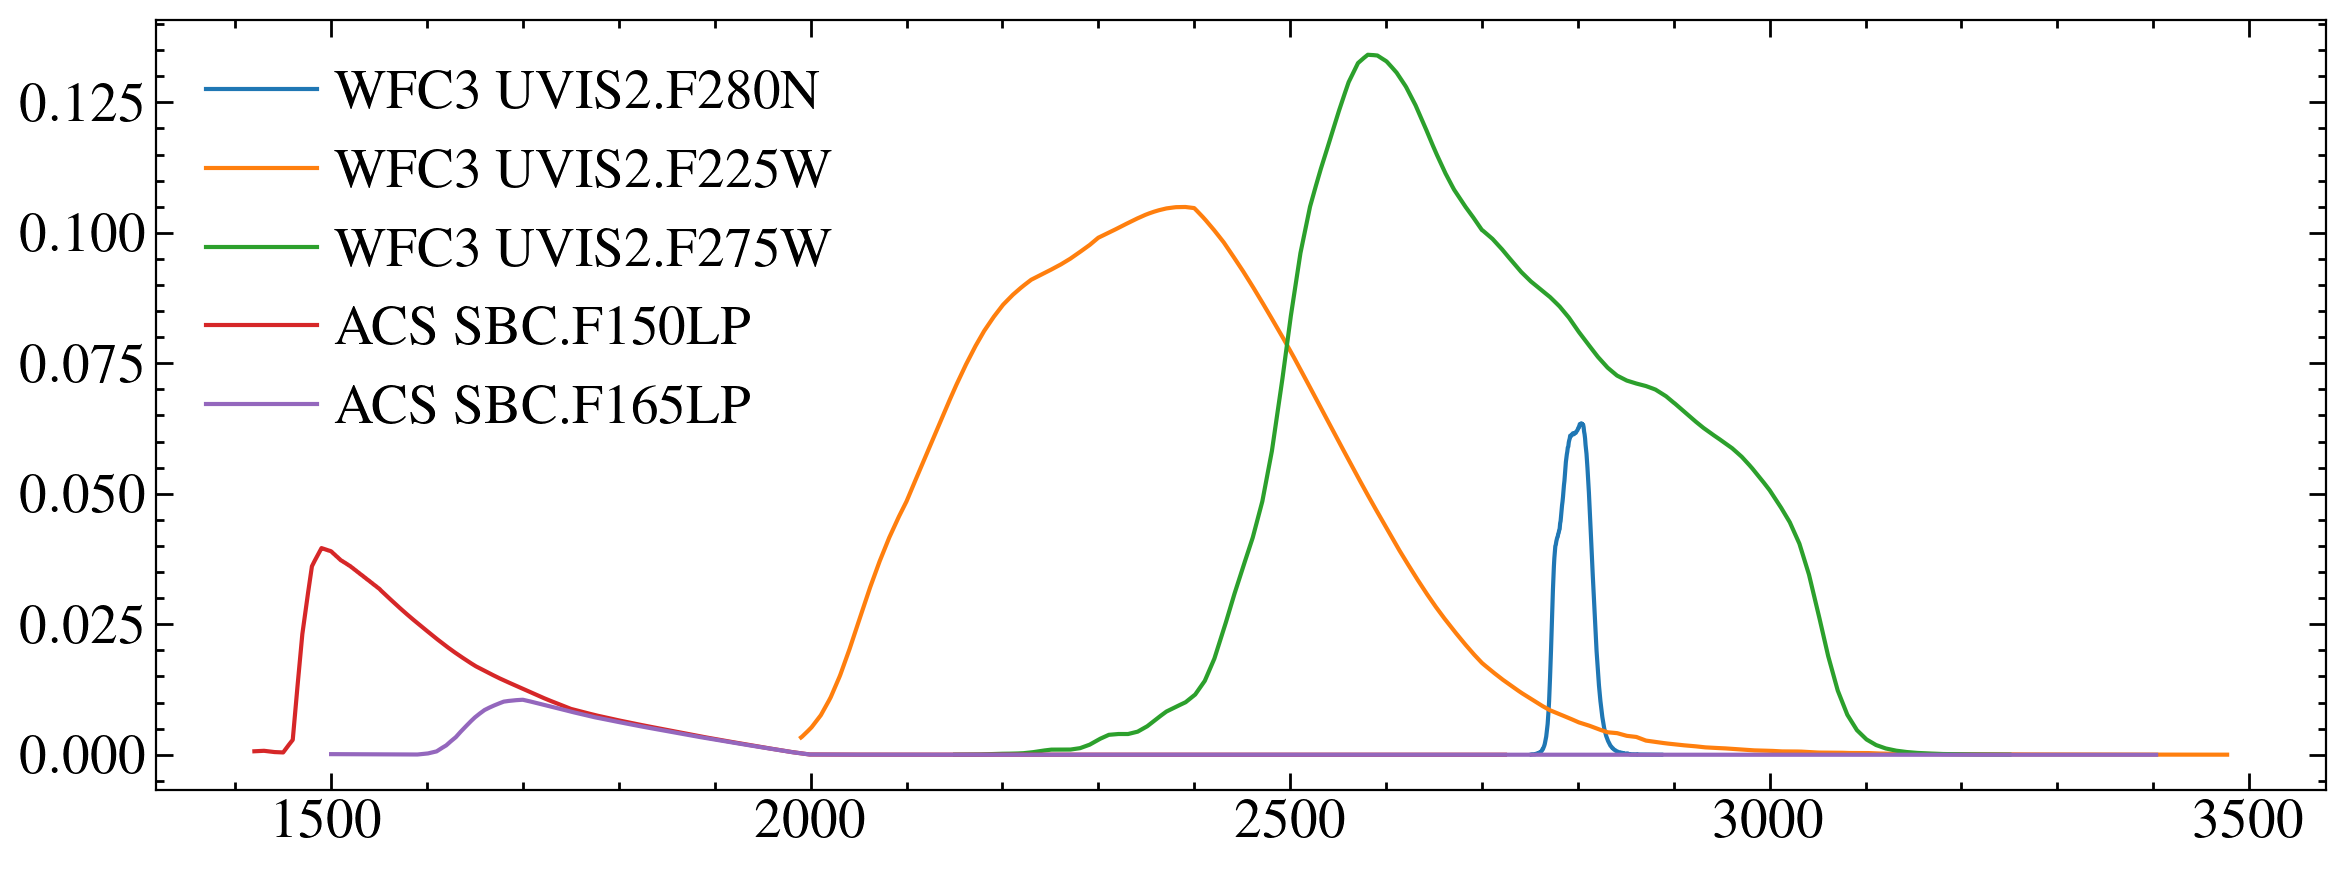

In [12]:
for flt in filters:
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    plt.plot(bpw, bpf, label = r'{}'.format(flt.replace('_', ' ')))
    print(min(bpf))

plt.legend()

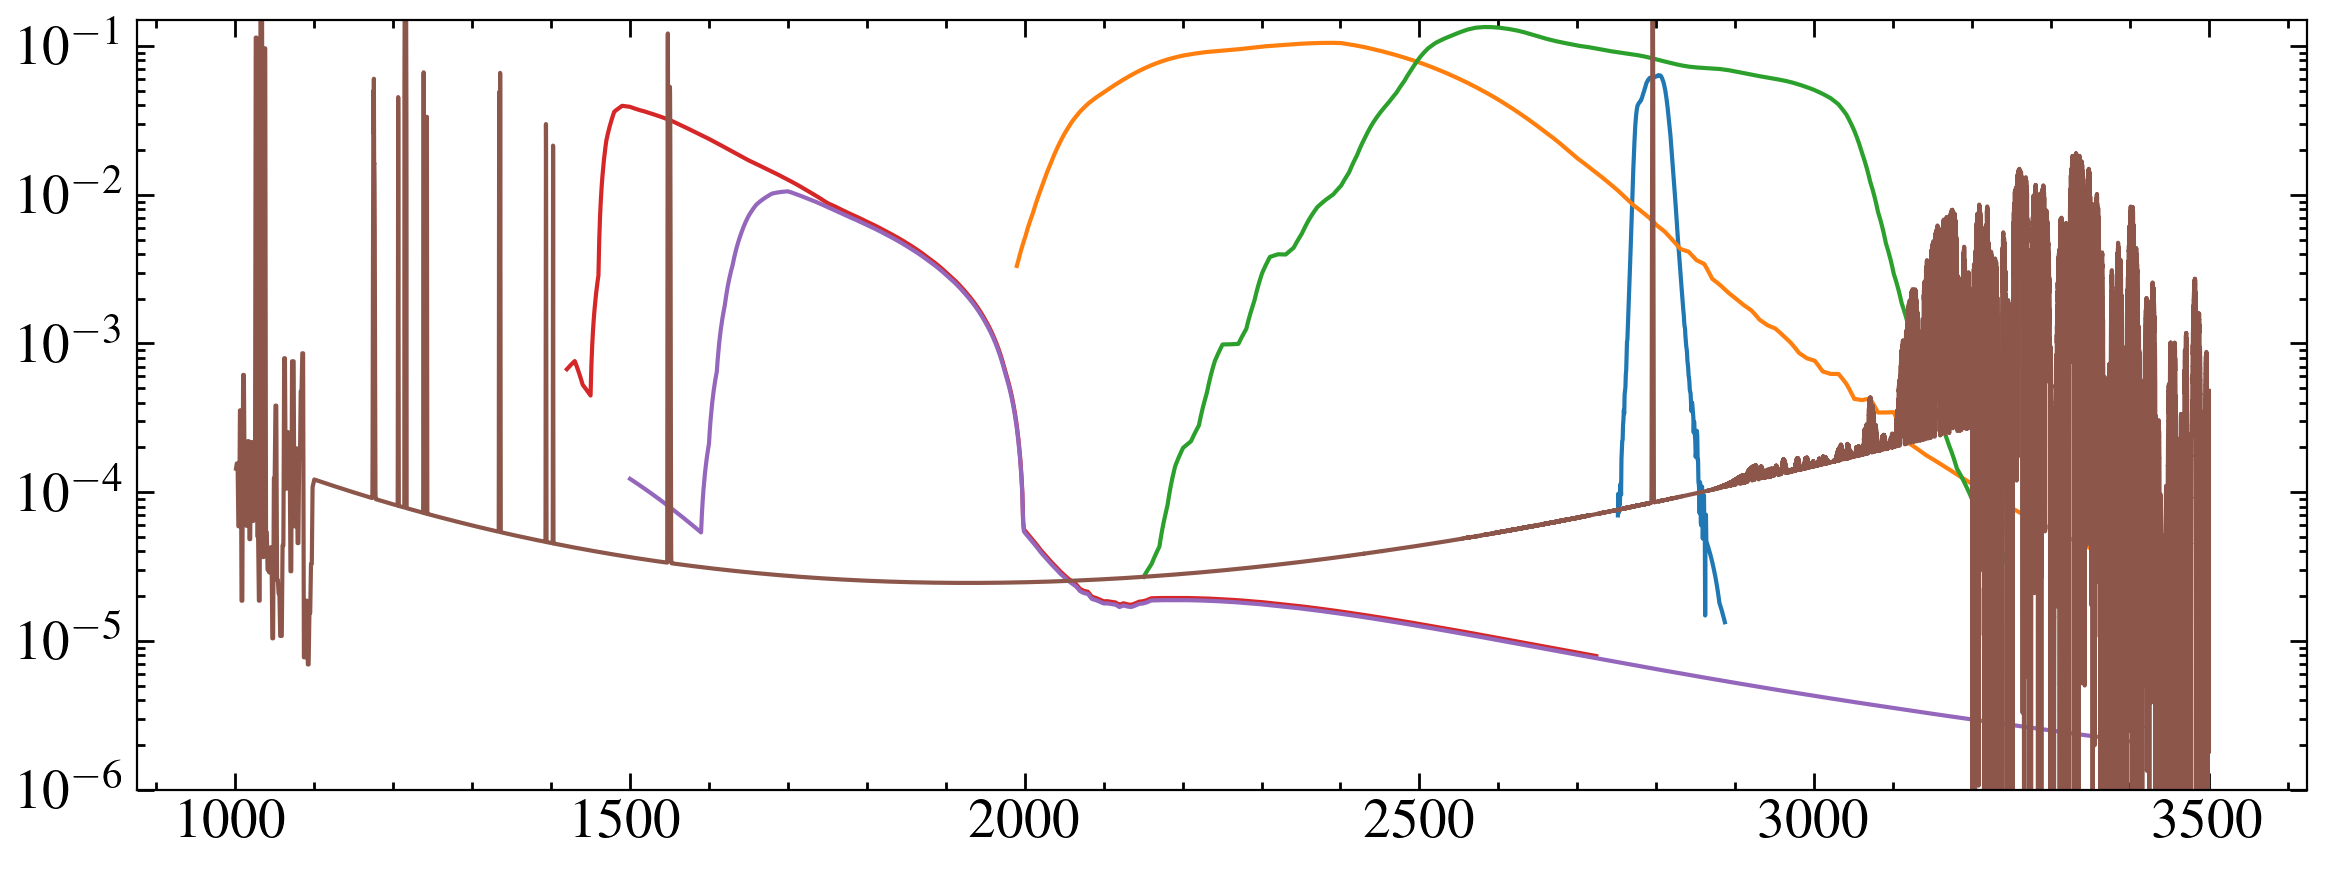

In [13]:

for flt in filters:
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    plt.plot(bpw, bpf, label = r'{}'.format(flt.replace('_', ' ')))

#plt.legend()
mask = (mw > 1000) & (mw < 3500)
umw, umf =  mw[mask], mf[mask]
plt.plot(umw, umf*5e14)
plt.ylim(0.000001, 0.15)
plt.yscale('log')

Plan- make a model spectrum file for each filter. Try with just a short one first,

In [14]:
# for flt in filters:
#     bp =  svo.Filter(flt)
#     bpw, bpf = (bp.wave[0].value)*10000, bp.throughput[0]
#     print(bpw[0], bpw[-1])

In [ ]:
#1230.0 3691.0
mask = (mw > 1220) & (mw < 3700)
umw, umf =  mw[mask], mf[mask]
savdat = Table([umw, umf], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 't1uv_model.dat', format='basic', overwrite=True)
plt.plot(umw, umf)

Idea- get a MUSCLES  NUV spectrum, scale to T1 distance, see if that works as an input. GJ 581 is an M5

In [ ]:
gjpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj581/'
gj_sed = '{}hlsp_muscles_multi_multi_gj581_broadband_v22_var-res-sed.fits'.format(gjpath)
gjdata = fits.getdata(gj_sed,1)

In [ ]:
gw, gf = gjdata['WAVELENGTH'], gjdata['FLUX']
plt.plot(gw, gf)
plt.plot(gw, gjdata['ERROR'])
plt.xscale('log')
plt.yscale('log')
plt.xlim(1700,3000)

In [ ]:
d_gj = (1/158.7491998297578e-3)*u.pc
d_t1 = 12.1*u.pc
print(d_gj)

In [ ]:
t1_nuv = Table.read('../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g230l_v6_component-spec.ecsv')
t1w, t1f = t1_nuv['WAVELENGTH'], t1_nuv['FLUX']

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(t1w, t1f)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.xlim(1650, 3200)
plt.ylim(-0.9e-15, 1.5e-15)
plt.tight_layout()

In [ ]:
scale = (d_gj/d_t1)**2
plt.plot(gw, gf)
plt.plot(gw, gf*scale)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1700,3000)
plt.plot(umw, umf)
plt.plot(t1w, t1f)

In [ ]:
plt.step(gw, gf*scale, where='mid')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(2700, 2900)
plt.ylim(0, 2e-15)
plt.step(t1w, t1f, where='mid')

Probably not? Can say it's a rough approximation for the etc

In [ ]:
mask = (gw > 1220) & (gw < 3700)
ugjw, ujgf =  gw[mask], gf[mask]
savdat = Table([ugjw, ujgf*scale], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'scaled_M5_uv.dat', format='basic', overwrite=True)

In [ ]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')
w, f, e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [ ]:
uvmask = (w > 1250) & (w < 3500)
t1w, t1f, t1e = w[uvmask],f[uvmask], e[uvmask]

In [ ]:
plt.plot(t1w, t1f)

Just plot the raw spectra with emission lines noted and filters?

In [16]:
components = glob.glob('../test_files/components/*.ecsv')
components


['../test_files/components/hlsp_muscles_xmm_epic_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g130m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g230l_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g140m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_apec_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_cos_2mass-j23062928-0502285_g160m_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_phx_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_dem_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_model_lya-reconstruction_2mass-j23062928-0502285_na_v6_component-spec.ecsv',
 '../test_files/components/hlsp_muscles_hst_stis_2mass-j230629

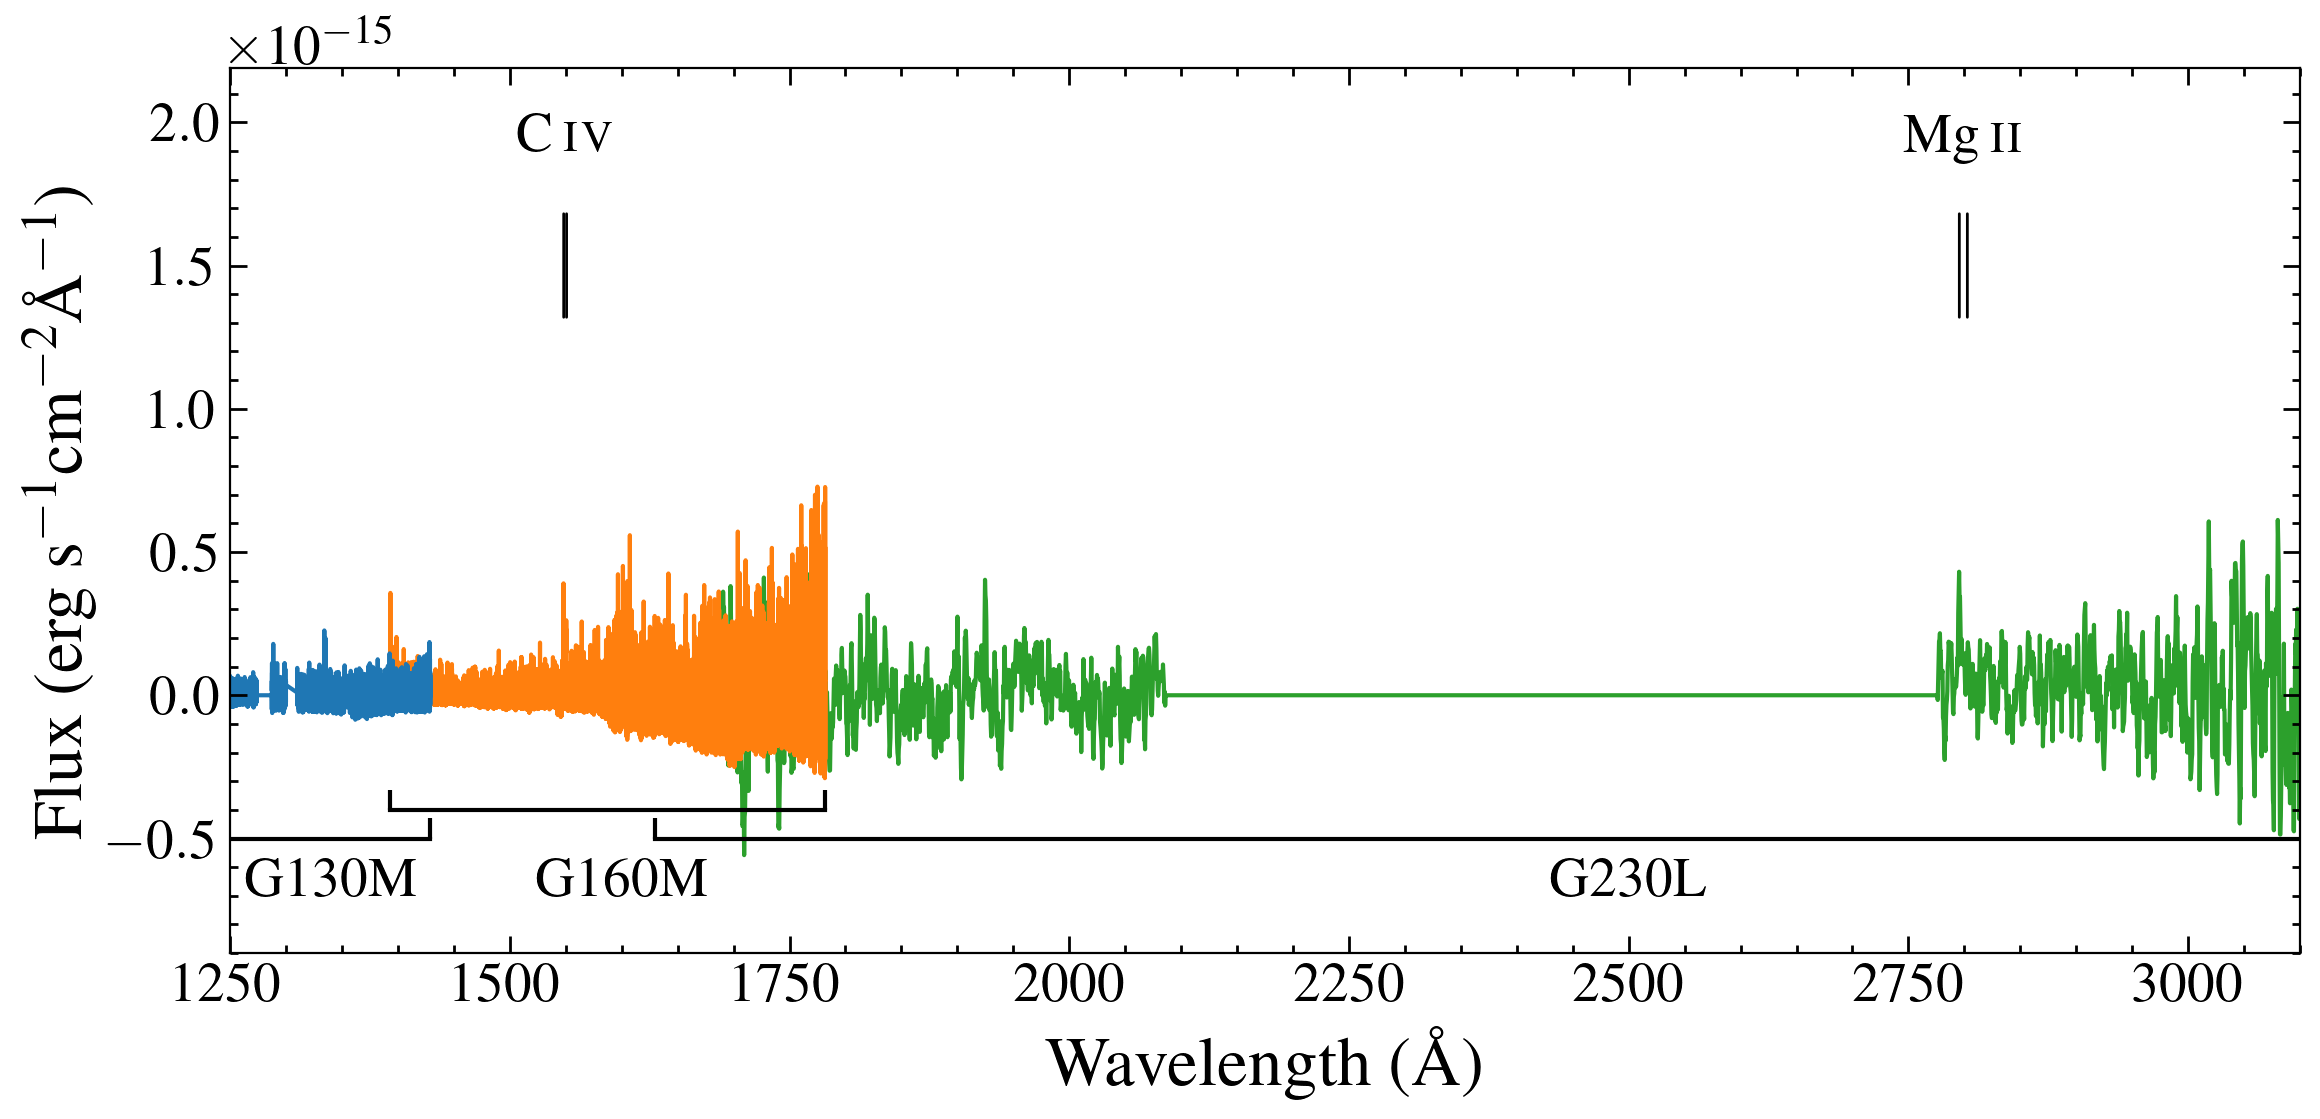

In [18]:
filters =  ['WFC3_UVIS2.F280N', 'WFC3_UVIS2.F225W', 'WFC3_UVIS2.F275W', 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']

plt.figure(figsize=(12, 6))
w0s = []
w1s = []
for i, spec in enumerate([components[1], components[5], components[2]]):
    data = Table.read(spec)
    w, f = data['WAVELENGTH'], data['FLUX']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f = w[mask], f[mask]
    f = convolve(f,Box1DKernel(5))
    plt.plot(w, f, zorder=-i)
    w0s.append(w[0])
    w1s.append(w[-1])
plt.ylim(-0.9e-15, 2.19e-15)
#plt.xscale('log')
for flt in filters:
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    plt.plot(bpw, bpf, label = r'{}'.format(flt.replace('_', ' ')))
plt.xlim(1250, 3100)

liney = -0.5e-15
labely = -0.7e-15
ticklength = 0.1*abs(labely)
plt.errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G130M', (1340, labely), horizontalalignment='center')

plt.errorbar((w0s[1],w1s[1]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G160M', (1600, labely), horizontalalignment='center')

plt.errorbar((w0s[2],w1s[2]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G230L', (2500, labely), horizontalalignment='center')

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
plt.xlabel('Wavelength (\AA)', size=25)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 1.3e-15), xytext=(line, 1.7e-15),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 2.e-15), xytext=(np.mean(si), 1.9e-15), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)

plt.tight_layout()

Same plot but with zoom in panels on the lines

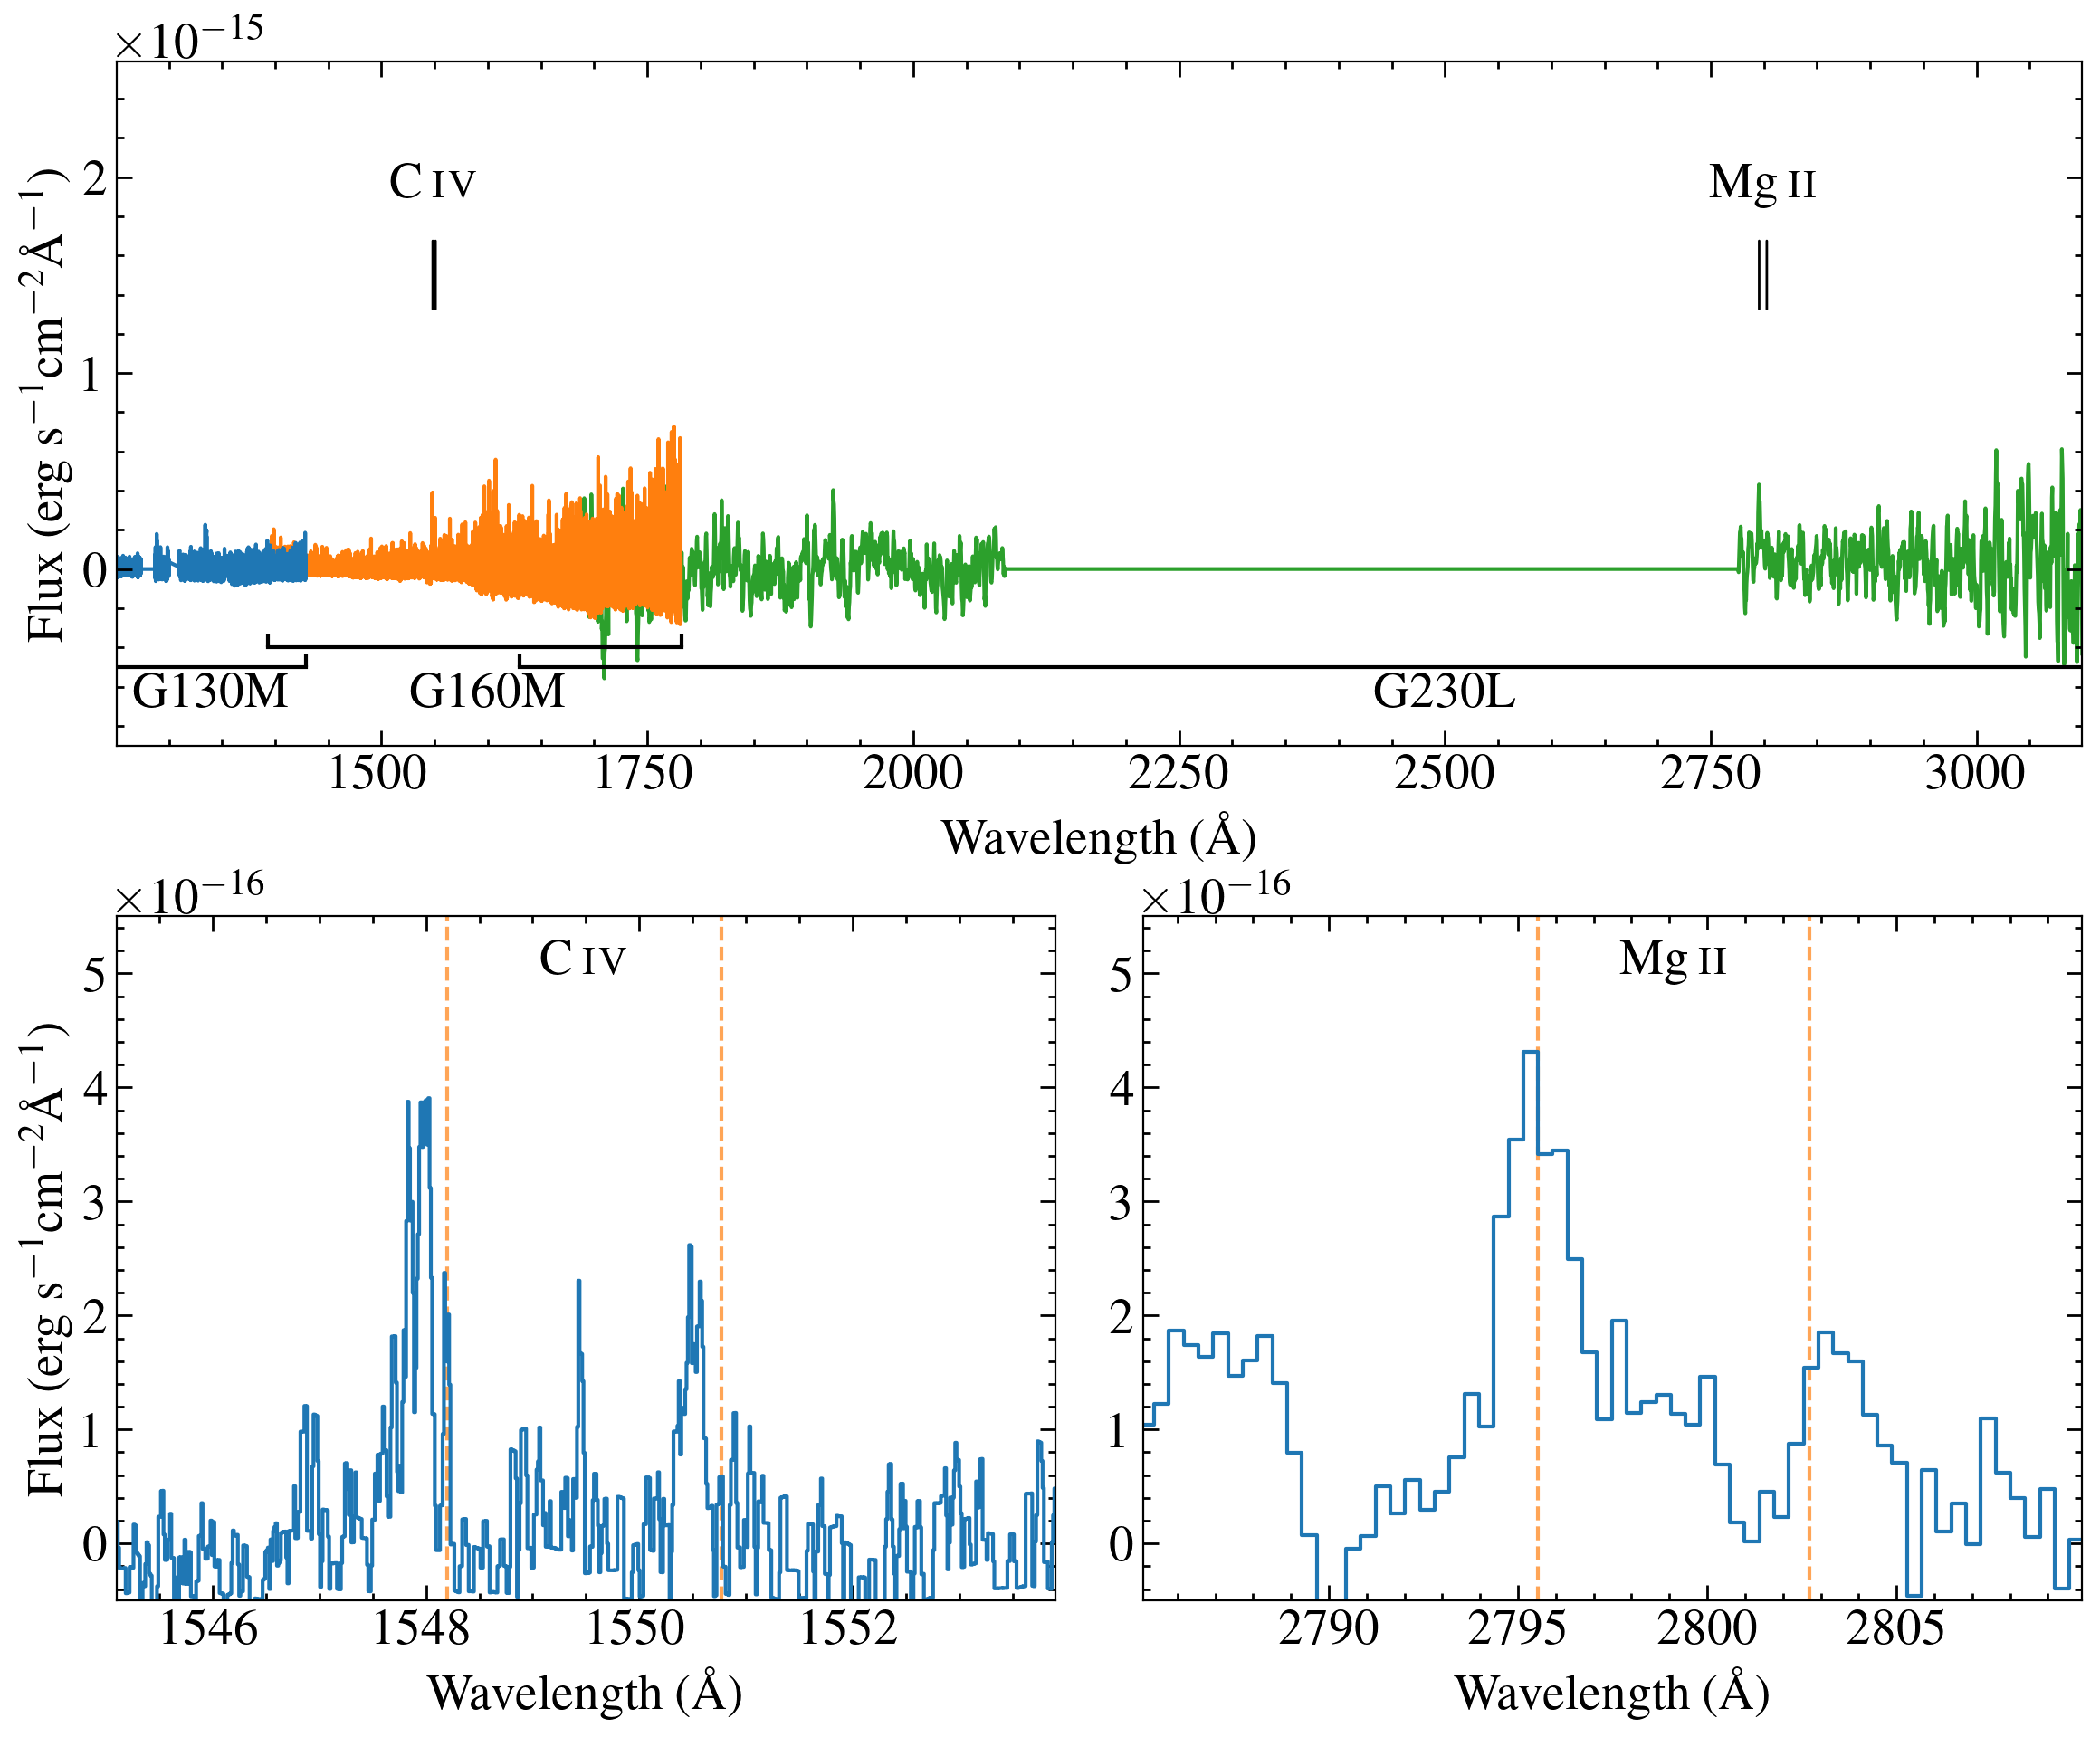

In [20]:
filters =  ['WFC3_UVIS2.F280N', 'WFC3_UVIS2.F225W', 'WFC3_UVIS2.F275W', 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']

plt.figure(figsize=(12, 10))
plt.subplot(211)

w0s = []
w1s = []
for i, spec in enumerate([components[1], components[5], components[2]]):
    data = Table.read(spec)
    w, f = data['WAVELENGTH'], data['FLUX']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f = w[mask], np.array(f[mask])
    f = convolve(f,Box1DKernel(5))
    plt.plot(w[50:-50], f[50:-50], zorder=-i)
    w0s.append(w[0])
    w1s.append(w[-1])
plt.ylim(-0.9e-15, 2.59e-15)
#plt.xscale('log')

shift = [70, 0, 0, -20,0]# ofset filter labels
for i, flt in enumerate(filters):
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    #print(bp.name)
    plt.plot(bpw, bpf, lw=2, ls='--', label = r'{}'.format(flt.replace('_', ' ')), c='C{}'.format(i+3))
    # label = flt[flt.find('.')+1:]
    # plt.annotate(label, (bp.WavelengthRef+shift[i], 2.3e-15), horizontalalignment='center', c='C{}'.format(i+3))
plt.xlim(1251, 3099)

liney = -0.5e-15
labely = -0.7e-15
ticklength = 0.1*abs(labely)
plt.errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G130M', (1340, labely), horizontalalignment='center')

plt.errorbar((w0s[1],w1s[1]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G160M', (1600, labely), horizontalalignment='center')

plt.errorbar((w0s[2],w1s[2]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
plt.annotate('G230L', (2500, labely), horizontalalignment='center')

plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.xlabel('Wavelength (\AA)', size=20)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 1.3e-15), xytext=(line, 1.7e-15),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 2.e-15), xytext=(np.mean(si), 1.9e-15), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)


plt.subplot(223)
data = Table.read(components[5])
w, f = data['WAVELENGTH'], np.array(data['FLUX'])
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
plt.step(w, f, where='mid')
plt.xlim(1545.1, 1553.9)
plt.ylim(-0.5e-16, 5.5e-16)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[plt.axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in c4]
plt.annotate(names[0],(np.mean(c4), 5e-16), xytext=(np.mean(c4), 5e-16), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.xlabel('Wavelength (\AA)', size=20)



plt.subplot(224)
data = Table.read(components[2])
w, f = data['WAVELENGTH'], np.array(data['FLUX'])
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
plt.step(w, f, where='mid')
plt.xlim(2785.1, 2809.9)
plt.ylim(-0.5e-16, 5.5e-16)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[plt.axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in mg2]
plt.annotate(names[1],(np.mean(mg2), 5e-16), xytext=(np.mean(mg2), 5e-16), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
#plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
plt.xlabel('Wavelength (\AA)', size=20)


plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('filters_and_lines.pdf')

In [ ]:
# acs = ['ACS_SBC.F165LP', 'ACS_SBC.F150LP']

# for flt in acs:
#     bp =  svo.Filter(flt)
#     bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
#     #print(bp.name)
#     plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))
#     print(min(bpf))
# [plt.axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in c4]
# # plt.xlim(1400, 1700)

Need a demo of M dwarfs compared with the sun- use the two M5 from MUSCLES?

In [ ]:
# mpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/'
# stars = ['gj876', 'gj581']
# for star in stars:
#     fpath = '{}{}/hlsp_muscles_multi_multi_{}_broadband_v22_adapt-const-res-sed.fits'.format(mpath, star, star)
#     data = fits.getdata(fpath, 1)
#     wm5, fm5 = data['WAVELENGTH'], data['FLUX'] 
#     plt.plot(wm5, fm5/np.max(fm5), label=star.upper())
    
# sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
# w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
# plt.plot(w_sol, f_sol/np.max(f_sol), label='Sun', zorder=-1, alpha =0.5)
# plt.ylim(5e-8, 10)
# plt.xlim(6, 2e4)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Relative Flux')
# plt.legend()
# plt.tight_layout()
# plt.savefig('m5_comparison.pdf')

In [ ]:
# filters =  [ 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']
# for flt in filters:
#     bp =  svo.Filter(flt)
#     bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
#     #print(bp.name)
#     plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))
#     print(min(bpf))
# plt.xlim(1400, 1700)
# plt.legend()

In [21]:
# # new uv model

# model = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/TRAPPIST-1/hlsp_muscles_multi_multi_trappist-1_broadband_v10_const-res-sed.fits', 1)
# mw, mf = model['WAVELENGTH'], model['FLUX']
# mask = (mw > 1220) & (mw < 3700)
# umw, umf =  mw[mask], mf[mask]
# savdat = Table([umw, umf], names=['#WAVELENGTH', 'FLUX'])
# ascii.write(savdat, 't1fuv_model.dat', format='basic', overwrite=True)
# plt.plot(umw, umf)

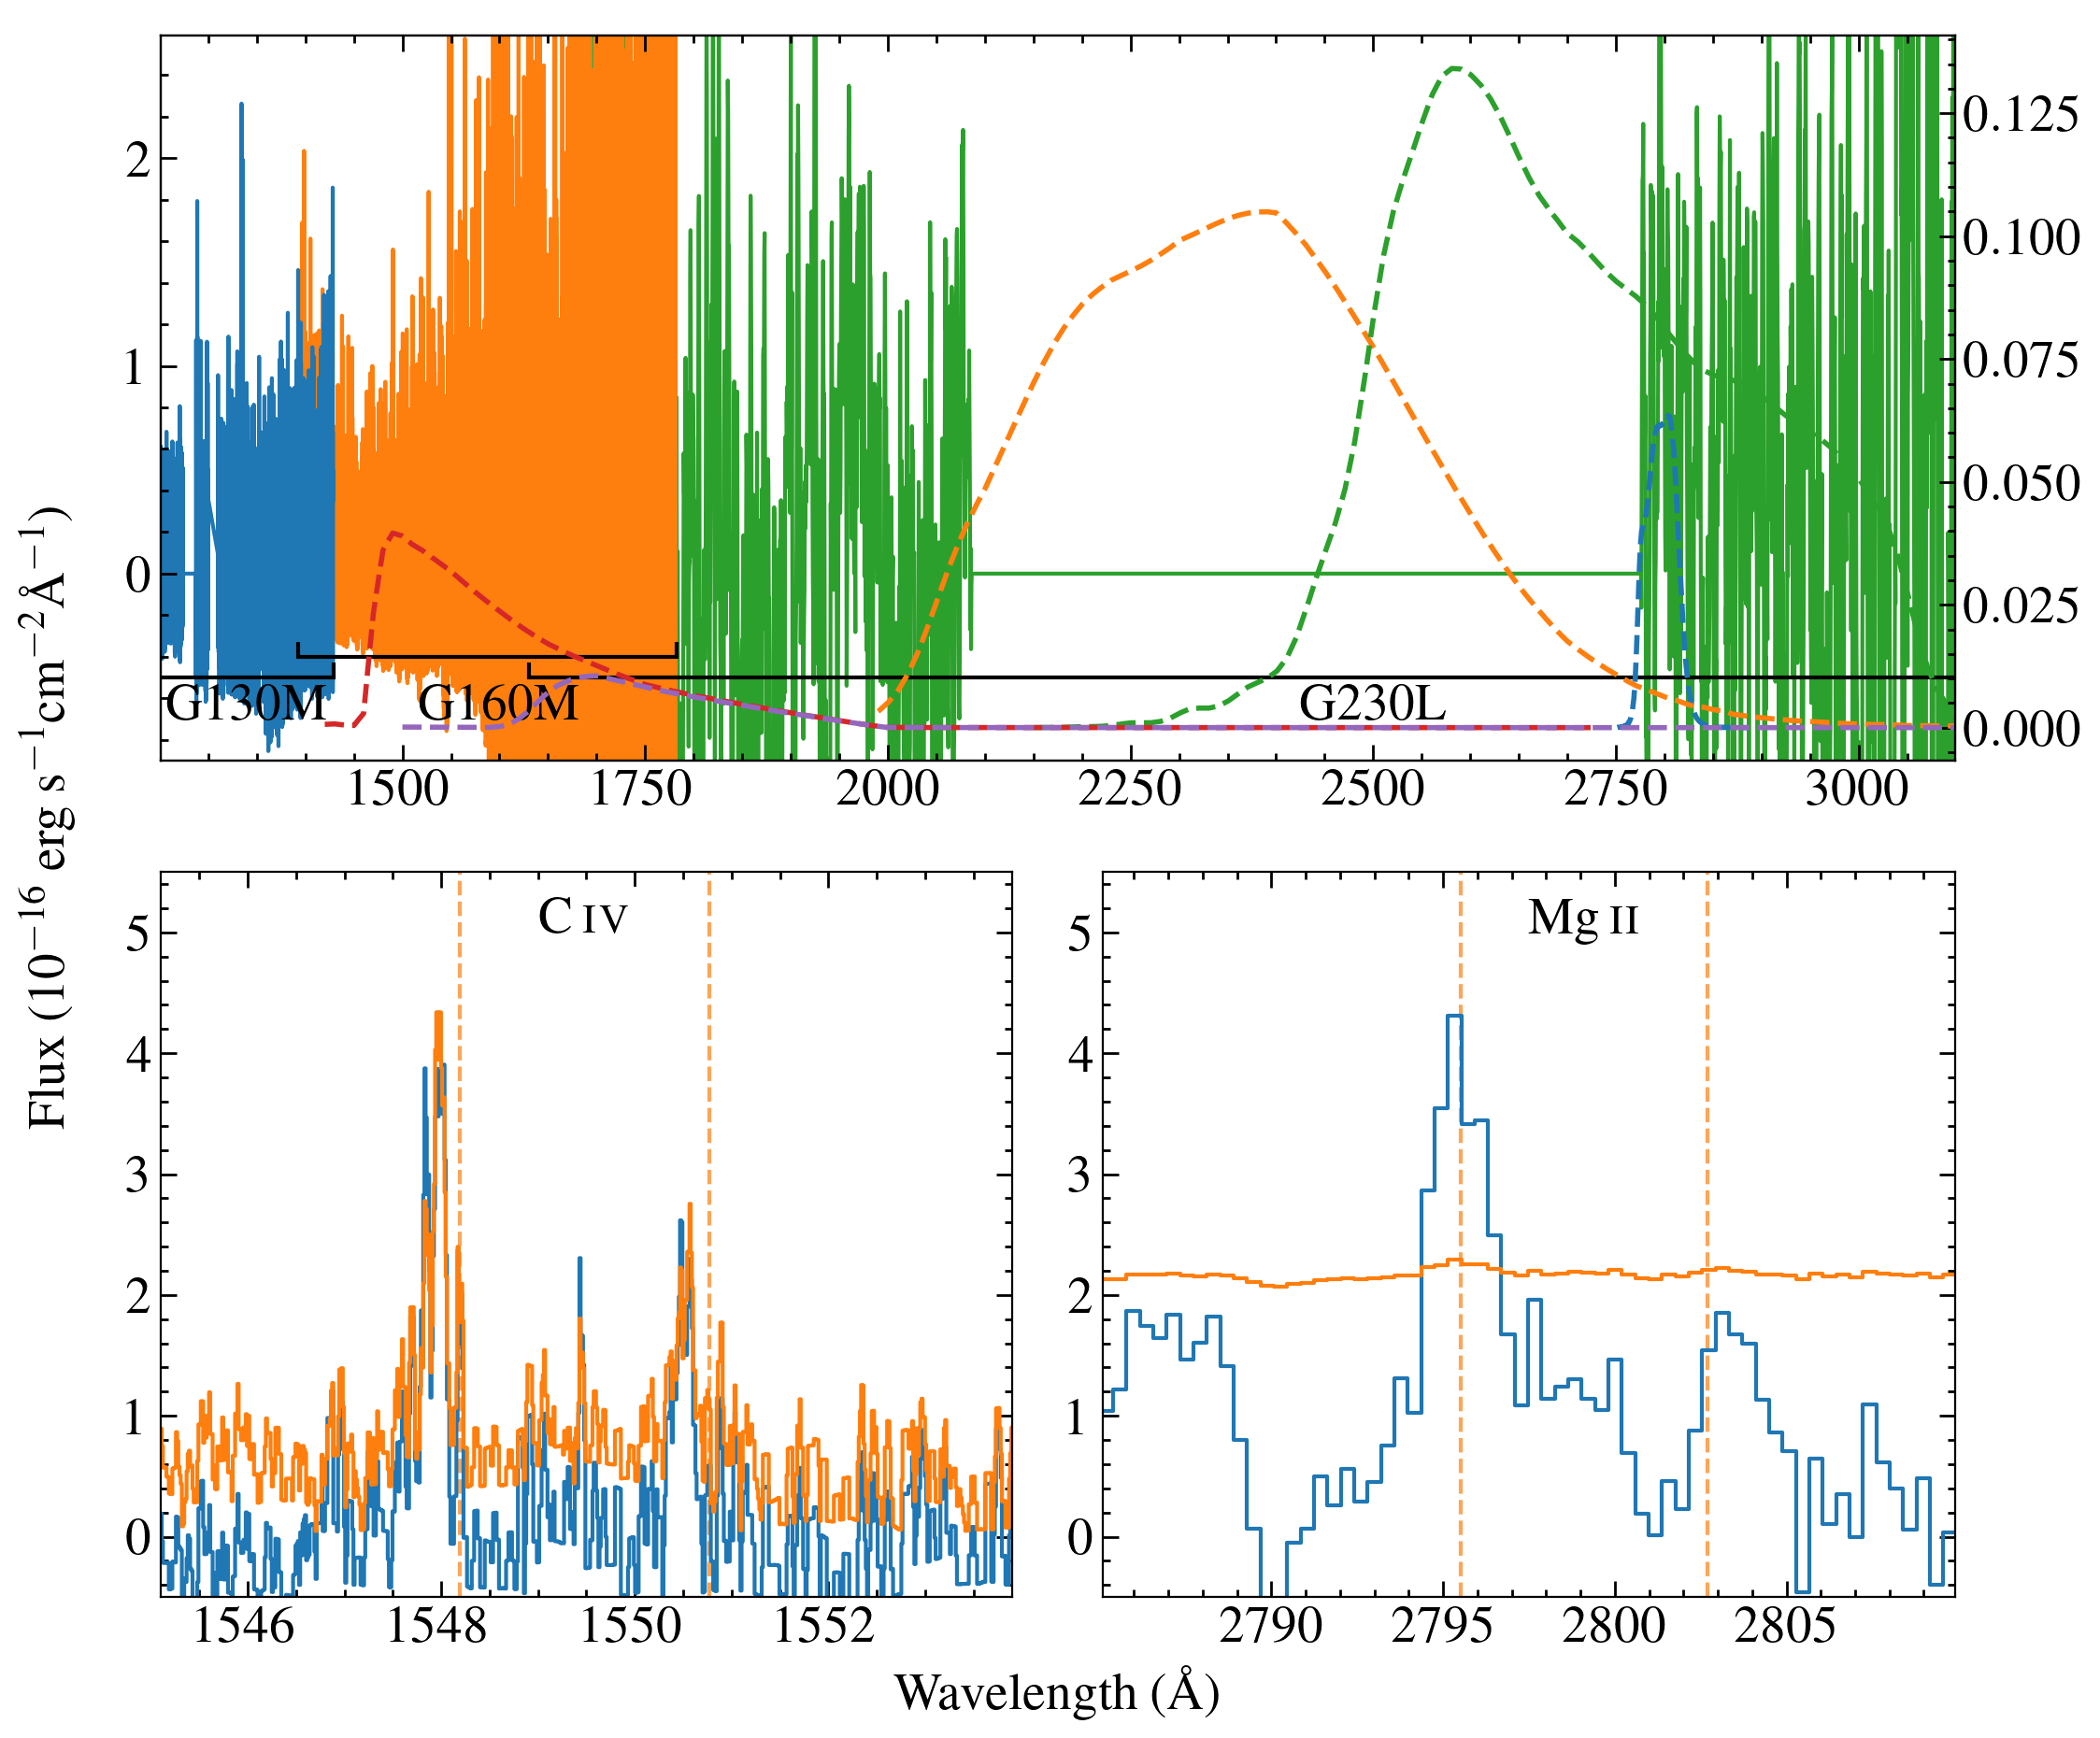

In [44]:
filters =  ['WFC3_UVIS2.F280N', 'WFC3_UVIS2.F225W', 'WFC3_UVIS2.F275W', 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']

fig, ax = plt.subplot_mosaic([[0, 0], [1, 2]], figsize=(12, 10))

# plt.figure(figsize=(12, 10))
# plt.subplot(211)
scale = 1e16

w0s = []
w1s = []
for i, spec in enumerate([components[1], components[5], components[2]]):
    data = Table.read(spec)
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f, e = w[mask], np.array(f[mask]), e[mask]
    f = convolve(f,Box1DKernel(5))
    ax[0].plot(w[50:-50], f[50:-50]*scale, zorder=-i)
    w0s.append(w[0])
    w1s.append(w[-1])
ax[0].set_ylim(-0.9, 2.59)
#plt.xscale('log')

shift = [70, 0, 0, -20,0]# ofset filter labels
ax2 = ax[0].twinx()
for i, flt in enumerate(filters):
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    #print(bp.name)
    ax2.plot(bpw, bpf, lw=2, ls='--')#, label = r'{}'.format(flt.replace('_', ' ')), c='C{}'.format(i+3))
    # label = flt[flt.find('.')+1:]
    # plt.annotate(label, (bp.WavelengthRef+shift[i], 2.3e-15), horizontalalignment='center', c='C{}'.format(i+3))
ax[0].set_xlim(1251, 3099)

liney = -0.5
labely = -0.7
ticklength = 0.1*abs(labely)
ax[0].errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
ax[0].annotate('G130M', (1340, labely), horizontalalignment='center')

ax[0].errorbar((w0s[1],w1s[1]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
ax[0].annotate('G160M', (1600, labely), horizontalalignment='center')

ax[0].errorbar((w0s[2],w1s[2]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
ax[0].annotate('G230L', (2500, labely), horizontalalignment='center')

# ax[0].set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
# ax[0].set_xlabel('Wavelength (\AA)', size=20)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 1.3), xytext=(line, 1.7),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 2), xytext=(np.mean(si), 1.9), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)


# plt.subplot(223)
data = Table.read(components[5])
w, f, e = data['WAVELENGTH'], np.array(data['FLUX']), data['ERROR']
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
e = convolve(e,Box1DKernel(5))

ax[1].step(w, f*scale, where='mid')
ax[1].step(w, e*scale, where='mid')
ax[1].set_xlim(1545.1, 1553.9)
ax[1].set_ylim(-0.5, 5.5)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[ax[1].axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in c4]
ax[1].annotate(names[0],(np.mean(c4), 5), xytext=(np.mean(c4), 5), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
# ax[1].set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
# ax[1].set_xlabel('Wavelength (\AA)', size=20)



# plt.subplot(224)
data = Table.read(components[2])
w, f, e = data['WAVELENGTH'], np.array(data['FLUX']), data['ERROR']
#w, f = w[mask], np.array(f[mask])
f = convolve(f,Box1DKernel(5))
e = convolve(e,Box1DKernel(5))
ax[2].step(w, f*scale, where='mid')
ax[2].step(w, e*scale, where='mid')
ax[2].set_xlim(2785.1, 2809.9)
ax[2].set_ylim(-0.5, 5.5)


#[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
[ax[2].axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in mg2]
ax[2].annotate(names[1],(np.mean(mg2), 5), xytext=(np.mean(mg2), 5), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
#plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
# ax[2].set_xlabel('Wavelength (\AA)', size=20)

bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_xlabel('Wavelength (\AA)', size=20)
bigax.set_ylabel('Flux (10$^{-16}$ erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)



fig.tight_layout()
# fig.subplots_adjust(hspace=0.25)
# plt.savefig('filters_and_lines.pdf')

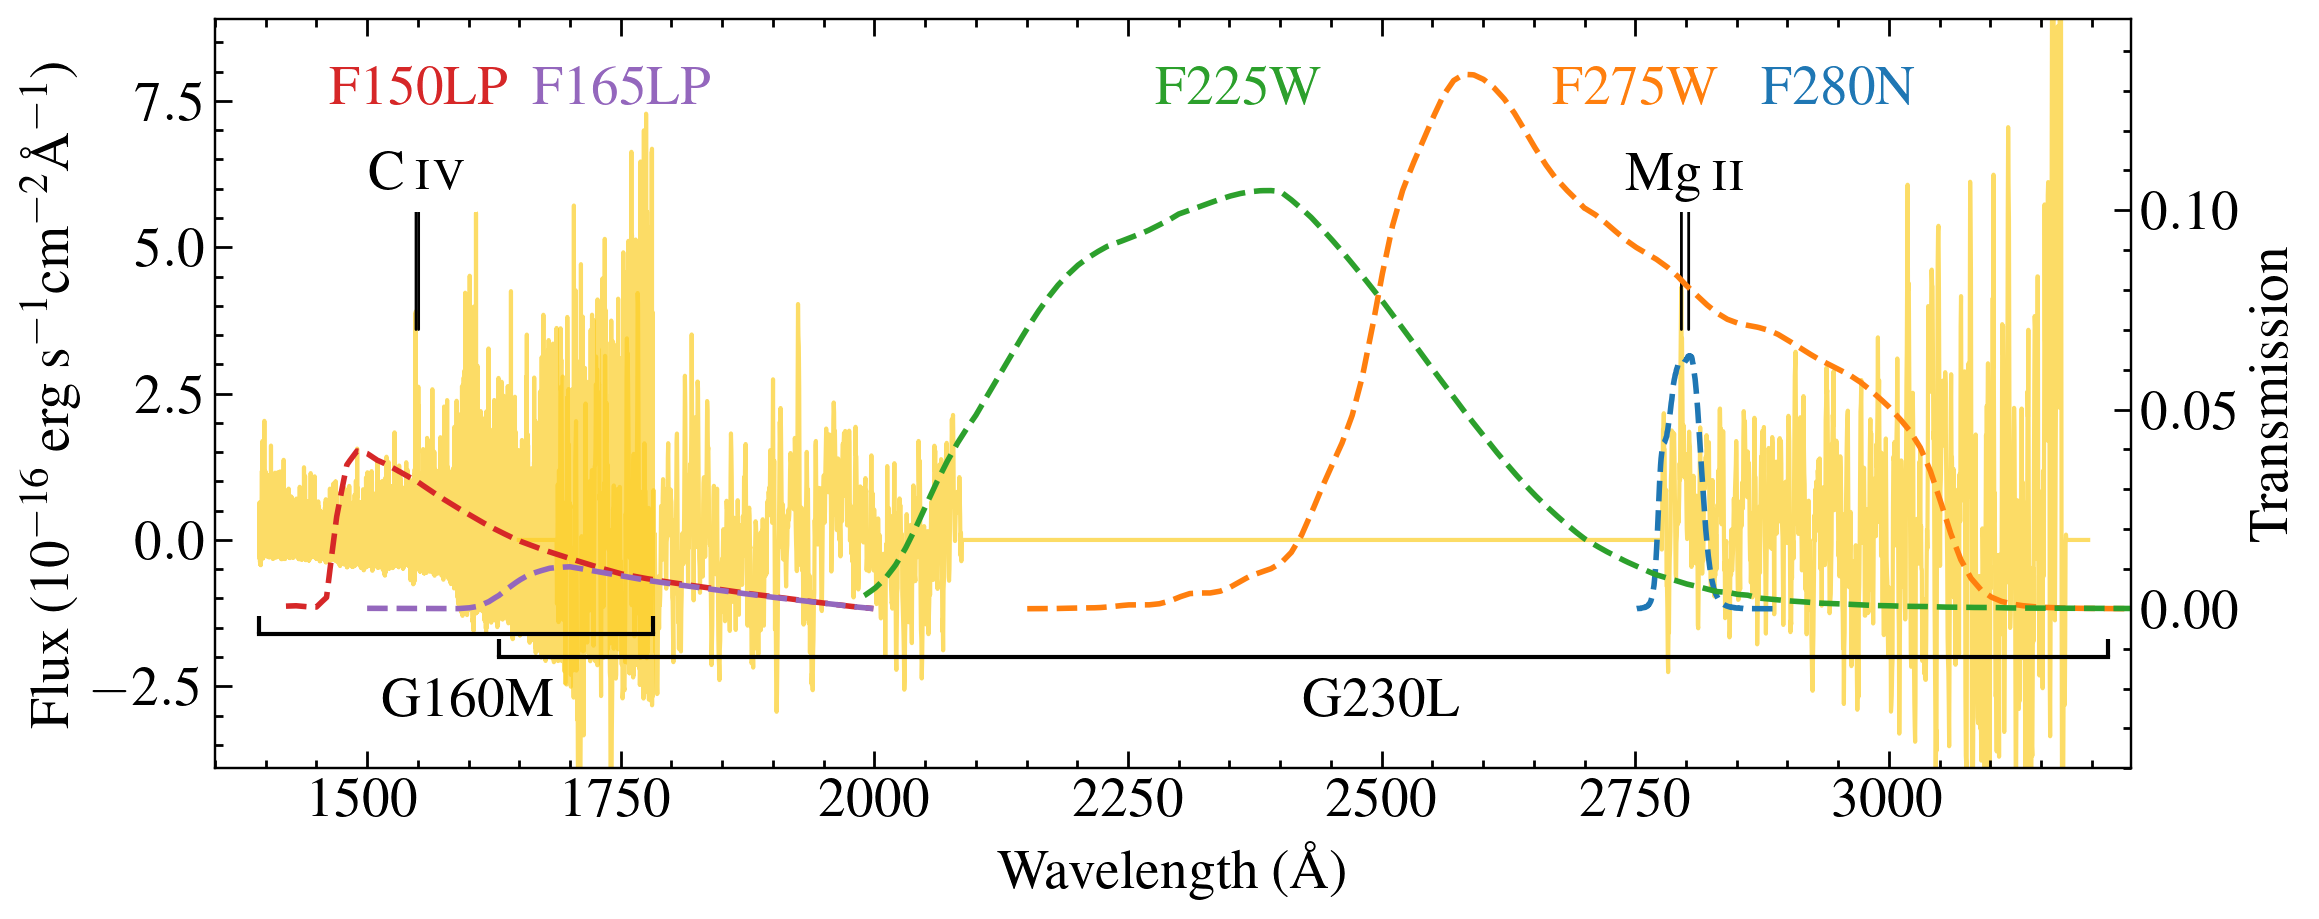

In [95]:
filters =  ['WFC3_UVIS2.F280N', 'WFC3_UVIS2.F275W', 'WFC3_UVIS2.F225W', 'ACS_SBC.F150LP', 'ACS_SBC.F165LP']
filter_name =  ['F280N', 'F275W', 'F225W', 'F150LP', 'F165LP']
filter_ws = [2950, 2750, 2358.7, 1550, 1750 ] #just for labels

fig, ax = plt.subplot_mosaic([[0, 0]], figsize=(12, 5))

# plt.figure(figsize=(12, 10))
# plt.subplot(211)
scale = 1e16

cols = [plt.cm.plasma(0.1)]


w0s = []
w1s = []
for i, spec in enumerate([components[5], components[2]]):
    data = Table.read(spec)
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    #airglow =  [1207, 1222, 1300, 1310, 1353, 1356]
    mask = (w < 1207) | (w > 1222) & (w < 1300) | (w > 1310) & (w < 1353) | (w > 1356) 
    w, f, e = w[mask], np.array(f[mask]), e[mask]
    f = convolve(f,Box1DKernel(5))
    ax[0].plot(w[50:-50], f[50:-50]*scale, zorder=-i, c=plt.cm.plasma(0.9), alpha=0.7)
    w0s.append(w[0])
    w1s.append(w[-1])
ax[0].set_ylim(-3.9, 8.9)
# ax[0].set_xscale('log')

shift = [70, 0, 0, -20,0]# ofset filter labels
ax2 = ax[0].twinx()
for i, flt in enumerate(filters):
    bpw, bpf = np.loadtxt('filters/HST_{}.dat'.format(flt), unpack=True)
    #print(bp.name)
    if i > 2:
        bpw, bpf = bpw[bpw< 2000], bpf[bpw< 2000]
    ax2.plot(bpw, bpf, lw=2, ls='--')#, label = r'{}'.format(flt.replace('_', ' ')), c='C{}'.format(i+3))
    ax2.annotate(filter_name[i], (filter_ws[i], 0.13), ha='center', va='center', c='C{}'.format(i))
    
    # label = flt[flt.find('.')+1:]
    # plt.annotate(label, (bp.WavelengthRef+shift[i], 2.3e-15), horizontalalignment='center', c='C{}'.format(i+3))
ax[0].set_xlim(1350, 3239)

ax2.set_ylim(-0.04, 0.148)

liney = -2
labely = -3
ticklength = 0.1*abs(labely)
# ax[0].errorbar((w0s[0],w1s[0]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
# ax[0].annotate('G130M', (1340, labely), horizontalalignment='center')

ax[0].errorbar((w0s[0],w1s[0]),(0.8*liney, 0.8*liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
ax[0].annotate('G160M', (1600, labely), horizontalalignment='center')

ax[0].errorbar((w0s[1],w1s[1]),(liney, liney), yerr= [[0,0], [ticklength,ticklength]], c ='k')
ax[0].annotate('G230L', (2500, labely), horizontalalignment='center')

# ax[0].set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
# ax[0].set_xlabel('Wavelength (\AA)', size=20)

c4 = [1548.195, 1550.77]
mg2 = [2795.523, 2802.697]

names = ['C\,{\sc iv}', 'Mg\,{\sc ii}']
lines = [c4, mg2]
for name, si in zip(names, lines):
    [ax[0].annotate('',(line, 3.5), xytext=(line, 5.8),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    ax[0].annotate(name,(np.mean(si), 3), xytext=(np.mean(si), 6), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

#plt.legend(loc=1)


# plt.subplot(223)
# data = Table.read(components[5])
# w, f, e = data['WAVELENGTH'], np.array(data['FLUX']), data['ERROR']
# #w, f = w[mask], np.array(f[mask])
# f = convolve(f,Box1DKernel(5))
# e = convolve(e,Box1DKernel(5))

# ax[1].step(w, f*scale, where='mid')
# ax[1].step(w, e*scale, where='mid')
# ax[1].set_xlim(1545.1, 1553.9)
# ax[1].set_ylim(-0.5, 5.5)


# #[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
# [ax[1].axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in c4]
# ax[1].annotate(names[0],(np.mean(c4), 5), xytext=(np.mean(c4), 5), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
# # ax[1].set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
# # ax[1].set_xlabel('Wavelength (\AA)', size=20)



# # plt.subplot(224)
# data = Table.read(components[2])
# w, f, e = data['WAVELENGTH'], np.array(data['FLUX']), data['ERROR']
# #w, f = w[mask], np.array(f[mask])
# f = convolve(f,Box1DKernel(5))
# e = convolve(e,Box1DKernel(5))
# ax[2].step(w, f*scale, where='mid')
# ax[2].step(w, e*scale, where='mid')
# ax[2].set_xlim(2785.1, 2809.9)
# ax[2].set_ylim(-0.5, 5.5)


# #[plt.annotate('',(line, 4e-16), xytext=(line, 4.8e-16),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in c4]
# [ax[2].axvline(line, c='C1', ls='--', alpha=0.7, zorder=-1) for line in mg2]
# ax[2].annotate(names[1],(np.mean(mg2), 5), xytext=(np.mean(mg2), 5), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
# #plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
# # ax[2].set_xlabel('Wavelength (\AA)', size=20)

# bigax = fig.add_subplot(111, frame_on=False)
# bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
ax[0].set_xlabel('Wavelength (\AA)', size=20)
ax[0].set_ylabel('Flux (10$^{-16}$ erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
ax2.set_ylabel('Transmission')

fig.tight_layout()
# fig.subplots_adjust(hspace=0.25)
fig.savefig('plots/plan.pdf')